# Combining Datasets

Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets, to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
``Series`` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

 ## Concat and Append



Here we'll take a look at simple concatenation of ``Series`` and ``DataFrame``s with the ``pd.concat`` function; later we'll dive into more sophisticated in-memory merges and joins implemented in Pandas.

We begin with the standard imports:

In [6]:
import pandas as pd
import numpy as np
import matplotlib as plt

For convenience, we'll define this function which creates a ``DataFrame`` of a particular form that will be useful below:

In [2]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special ``_repr_html_`` method, which IPython uses to implement its rich object display:

In [3]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

It is not necessary to understand or study this function.  The use of this function is to make it easier to understand how the operations work on multiple dataframes.  It will become clearer as we continue our discussion in the following section.  

## Simple Concatenation with ``pd.concat``

Pandas has a function, ``pd.concat()`` that contains a number of options that we'll discuss momentarily:

```python
# Signature in Pandas v0.18
pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
```

``pd.concat()`` can be used for a simple concatenation of ``Series`` or ``DataFrame`` objects, just as ``np.concatenate()`` can be used for simple concatenations of arrays:

In [4]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

It also works to concatenate higher-dimensional objects, such as ``DataFrame``s:

In [5]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
display('df1', 'df2', 'pd.concat([df1, df2])')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


By default, the concatenation takes place row-wise within the ``DataFrame`` (i.e., ``axis=0``).
Like ``np.concatenate``, ``pd.concat`` allows specification of an axis along which concatenation will take place.
Consider the following example:

In [6]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis=1)")

df3
    A   B
0  A0  B0
1  A1  B1

df4
    C   D
0  C0  D0
1  C1  D1

pd.concat([df3, df4], axis=1)
    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

### Duplicate indices

One important thing to know for ``pd.concat`` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this simple example:

In [7]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result.
While this is techinically valid within ``DataFrame``s, the outcome is often undesirable. Meaning avoid this unless you want a headache. 
``pd.concat()`` gives us a few ways to handle it.

#### Catching the repeats as an error

If you'd like to simply verify that the indices in the result of ``pd.concat()`` do not overlap, you can specify the ``verify_integrity`` flag.
With this set to True, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

In [8]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the ``ignore_index`` flag.
With this set to true, the concatenation will create a new integer index for the resulting ``Series``:

In [9]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys

Another option is to use the ``keys`` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data:

In [10]:
display('x', 'y', "pd.concat([x, y], keys=['x', 'y'])")

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys=['x', 'y'])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

### Concatenation with joins

In the simple examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and ``pd.concat`` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

In [11]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

By default, the entries for which no data is available are filled with NA values.
To change this, we can specify one of several options for the ``join`` and ``join_axes`` parameters of the concatenate function.
By default, the join is a union of the input columns (``join='outer'``), but we can change this to an intersection of the columns using ``join='inner'``:

In [12]:
display('df5', 'df6',
        "pd.concat([df5, df6], join='inner')")

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6], join='inner')
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

The combination of options of the ``pd.concat`` function allows a wide range of possible behaviors when joining two datasets; keep these in mind as you use these tools for your own data.

### The ``append()`` method

Because direct array concatenation is so common, ``Series`` and ``DataFrame`` objects have an ``append`` method that can accomplish the same thing in fewer keystrokes.
For example, rather than calling ``pd.concat([df1, df2])``, you can simply call ``df1.append(df2)``:

In [13]:
display('df1', 'df2', 'df1.append(df2)')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


Keep in mind that unlike the ``append()`` and ``extend()`` methods of Python lists, the ``append()`` method in Pandas does not modify the original object–instead it creates a new object with the combined data.
It also is not a very efficient method, because it involves creation of a new index *and* data buffer.
Thus, if you plan to do multiple ``append`` operations, it is generally better to build a list of ``DataFrame``s and pass them all at once to the ``concat()`` function.

In the next section, we'll look at another more powerful approach to combining data from multiple sources, the database-style merges/joins implemented in ``pd.merge``.
For more information on ``concat()``, ``append()``, and related functionality, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

# Combining Datasets: Merge and Join

One essential feature offered by Pandas is its high-performance, in-memory join and merge operations.
If you have ever worked with databases, you should be familiar with this type of data interaction.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.



## Relational Algebra

The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

## Categories of Joins

The ``pd.merge()`` function implements a number of types of joins: the *one-to-one*, *many-to-one*, and *many-to-many* joins.
All three types of joins are accessed via an identical call to the ``pd.merge()`` interface; the type of join performed depends on the form of the input data.
Here we will show simple examples of the three types of merges, and discuss detailed options further below.

### One-to-one joins

Perhaps the simplest type of merge expresion is the one-to-one join, which is in many ways very similar to the column-wise concatenation seen in [Combining Datasets: Concat & Append](03.06-Concat-And-Append.ipynb).
As a concrete example, consider the following two ``DataFrames`` which contain information on several employees in a company:

In [14]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2')

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Jake,2012
3,Sue,2014


To combine this information into a single ``DataFrame``, we can use the ``pd.merge()`` function:

In [15]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


The ``pd.merge()`` function recognizes that each ``DataFrame`` has an "employee" column, and automatically joins using this column as a key.
The result of the merge is a new ``DataFrame`` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "employee" column differs between ``df1`` and ``df2``, and the ``pd.merge()`` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the ``left_index`` and ``right_index`` keywords, discussed momentarily).

### Many-to-one joins

Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting ``DataFrame`` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

In [16]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

df3
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

df4
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve

pd.merge(df3, df4)
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve

The resulting ``DataFrame`` has an aditional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs.

### Many-to-many joins

Many-to-many joins are a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a ``DataFrame`` showing one or more skills associated with a particular group.
By performing a many-to-many join, we can recover the skills associated with any individual person:

In [17]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,coding
3,Engineering,linux
4,HR,spreadsheets


These three types of joins can be used with other Pandas tools to implement a wide array of functionality.
But in practice, datasets are rarely as clean as the one we're working with here.
In the following section we'll consider some of the options provided by ``pd.merge()`` that enable you to tune how the join operations work.

## Specification of the Merge Key

We've already seen the default behavior of ``pd.merge()``: it looks for one or more matching column names between the two inputs, and uses this as the key.
However, often the column names will not match so nicely, and ``pd.merge()`` provides a variety of options for handling this.

### The ``on`` keyword

Most simply, you can explicitly specify the name of the key column using the ``on`` keyword, which takes a column name or a list of column names:

In [18]:
display('df1', 'df2', "pd.merge(df1, df2, on='employee')")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2, on='employee')
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

This option works only if both the left and right ``DataFrame``s have the specified column name.

### The ``left_on`` and ``right_on`` keywords

At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee name is labeled as "name" rather than "employee".
In this case, we can use the ``left_on`` and ``right_on`` keywords to specify the two column names:

In [19]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on="employee", right_on="name")')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1, df3, left_on="employee", right_on="name")
  employee        group  name  salary
0      Bob   Accounting   Bob   70000
1     Jake  Engineering  Jake   80000
2     Lisa  Engineering  Lisa  120000
3      Sue           HR   Sue   90000

The result has a redundant column that we can drop if desired–for example, by using the ``drop()`` method of ``DataFrame``s:

In [20]:
pd.merge(df1, df3, left_on="employee", right_on="name").drop('name', axis=1)

,employee,group,salary
0,Bob,Accounting,70000
1,Jake,Engineering,80000
2,Lisa,Engineering,120000
3,Sue,HR,90000


### The ``left_index`` and ``right_index`` keywords

Sometimes, rather than merging on a column, you would instead like to merge on an index.
For example, your data might look like this:

In [21]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


You can use the index as the key for merging by specifying the ``left_index`` and/or ``right_index`` flags in ``pd.merge()``:

In [22]:
display('df1a', 'df2a',
        "pd.merge(df1a, df2a, left_index=True, right_index=True)")

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


For convenience, ``DataFrame``s implement the ``join()`` method, which performs a merge that defaults to joining on indices:

In [23]:
display('df1a', 'df2a', 'df1a.join(df2a)')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


If you'd like to mix indices and columns, you can combine ``left_index`` with ``right_on`` or ``left_on`` with ``right_index`` to get the desired behavior:

In [24]:
display('df1a', 'df3', "pd.merge(df1a, df3, left_index=True, right_on='name')")

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1a, df3, left_index=True, right_on='name')
         group  name  salary
0   Accounting   Bob   70000
1  Engineering  Jake   80000
2  Engineering  Lisa  120000
3           HR   Sue   90000

All of these options also work with multiple indices and/or multiple columns; the interface for this behavior is very intuitive.
For more information on this, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

## Specifying Set Arithmetic for Joins

In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.
This comes up when a value appears in one key column but not the other. Consider this example:

In [25]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7)
   name   food drink
0  Mary  bread  wine

Here we have merged two datasets that have only a single "name" entry in common: Mary.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the ``how`` keyword, which defaults to ``"inner"``:

In [26]:
pd.merge(df6, df7, how='inner')

,name,food,drink
0,Mary,bread,wine


Other options for the ``how`` keyword are ``'outer'``, ``'left'``, and ``'right'``.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

In [27]:
display('df6', 'df7', "pd.merge(df6, df7, how='outer')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='outer')
     name   food drink
0   Peter   fish   NaN
1    Paul  beans   NaN
2    Mary  bread  wine
3  Joseph    NaN  beer

The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

In [28]:
display('df6', 'df7', "pd.merge(df6, df7, how='left')")

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how='left')
    name   food drink
0  Peter   fish   NaN
1   Paul  beans   NaN
2   Mary  bread  wine

The output rows now correspond to the entries in the left input. Using
``how='right'`` works in a similar manner.

All of these options can be applied straightforwardly to any of the preceding join types.

## Overlapping Column Names: The ``suffixes`` Keyword

Finally, you may end up in a case where your two input ``DataFrame``s have conflicting column names.
Consider this example:

In [29]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name")
   name  rank_x  rank_y
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

Because the output would have two conflicting column names, the merge function automatically appends a suffix ``_x`` or ``_y`` to make the output columns unique.
If these defaults are inappropriate, it is possible to specify a custom suffix using the ``suffixes`` keyword:

In [30]:
display('df8', 'df9', 'pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name", suffixes=["_L", "_R"])
   name  rank_L  rank_R
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

These suffixes work in any of the possible join patterns, and work also if there are multiple overlapping columns.

For more information on these patterns, see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) where we dive a bit deeper into relational algebra.
Also see the [Pandas "Merge, Join and Concatenate" documentation](http://pandas.pydata.org/pandas-docs/stable/merging.html) for further discussion of these topics.

## Example: US States Data

Merge and join operations come up most often when combining data from different sources.
Here we will consider an example of some data about US states and their populations.
The data files can be found at http://github.com/jakevdp/data-USstates/:

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [31]:
pop = pd.read_csv('state-population.csv')
areas = pd.read_csv('state-areas.csv')
abbrevs = pd.read_csv('state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Given this information, say we want to compute a relatively straightforward result: rank US states and territories by their 2010 population density.
We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.
We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.
We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

In [32]:
merged = pd.merge(pop, abbrevs, how='outer',
                  left_on='state/region', right_on='abbreviation')
merged = merged.drop('abbreviation', axis=1) # drop duplicate info
merged.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

In [33]:
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state            True
dtype: bool

Some of the ``population`` info is null; let's figure out which these are!

In [34]:
merged[merged['population'].isnull()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [35]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [36]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

state/region    False
ages            False
year            False
population       True
state           False
dtype: bool

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the area data using a similar procedure.
Examining our results, we will want to join on the ``state`` column in both:

In [37]:
final = pd.merge(merged, areas, on='state', how='left')
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Again, let's check for nulls to see if there were any mismatches:

In [38]:
final.isnull().any()

state/region     False
ages             False
year             False
population        True
state            False
area (sq. mi)     True
dtype: bool

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [39]:
final['state'][final['area (sq. mi)'].isnull()].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [40]:
final.dropna(inplace=True)
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2000, and the total population.
We'll use the ``query()`` function to do this quickly (this requires the ``numexpr`` package to be installed; see [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)):

In [41]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state, and then compute the result:

In [42]:
data2010.set_index('state', inplace=True)
density = data2010['population'] / data2010['area (sq. mi)']

In [43]:
density.sort_values(ascending=False, inplace=True)
density.head()

state
District of Columbia    8898.897059
Puerto Rico             1058.665149
New Jersey              1009.253268
Rhode Island             681.339159
Connecticut              645.600649
dtype: float64

The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [44]:
density.tail()

state
South Dakota    10.583512
North Dakota     9.537565
Montana          6.736171
Wyoming          5.768079
Alaska           1.087509
dtype: float64

We see that the least dense state, by far, is Alaska, averaging slightly over one resident per square mile.

This type of messy data merging is a common task when trying to answer questions using real-world data sources.
I hope that this example has given you an idea of the ways you can combine tools we've covered in order to gain insight from your data!

# Excerise

This excercise will bring together skills from the last 3 weeks. 

In some of the previous weeks we have been looking at babyname popularity.   One problem with the way we were calculating popularity is that it was confounded by population growth.  That is more babies were born overall so an increase in the number of babies named e.g. "Michael" could just reflect population growth, and not that the name is actually growing in popularity.  Another way to quantify popularity is to use percentange.  That is, what percentage of all babies have a given name.  The percentage measure normalizes for the total number of babies born.   The excercise this week is to calculate the percentage of all births that each name accounts for and use this quantity to look at several things. 


## Calculate percentage

You can do this in a few steps.  

1) Create a new dataframe that has the total births for a given year. 

2) Join this new dataframe with the original dataframe 

3) Calculate the percentage and put it into a new column

## Use the percentage

What name had the biggest change in percentage popularity?  Show a table and a graph.

How much more diverse have names gotten over the century? Lot's of ways to quantify this.  We had looked at the number of unique names before.  Lets now try looking at the percentage of babies given the most popular name.  

There are also interesting social/cultural patterns.  What does the popularity graph for the name "Hillary" look like?  Can you suggest other names to try?




In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as plt

In [9]:
#I'll load the file for you.  Note the babynames file we've been using doesn't have labels for columns. 
#We explicitly label the columns using the "field_names" list vairable. 
ca_name = 'STATE.CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
babynames = pd.read_csv(ca_name, header=None, names=field_names)
babynames

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134
...,...,...,...,...,...
407423,CA,M,2022,Zayvier,5
407424,CA,M,2022,Zia,5
407425,CA,M,2022,Zora,5
407426,CA,M,2022,Zuriel,5


In [10]:
# 1) Create a new dataframe that has the total births for a given year. 

#Only inlcude the columns "Year" and "Count"  because that's all we need.  Making the output simpler
babynamesTotalByYear = babynames[['Year','Count']].groupby("Year").agg(sum)
babynamesTotalByYear

,Count
Year,
1910,9163
1911,9983
1912,17946
1913,22094
1914,26926
...,...
2018,395436
2019,386996
2020,362882


In [11]:
# 2) Join this new dataframe with the original dataframe 

babynames=pd.merge(babynames,babynamesTotalByYear,left_on="Year",right_index=True)

In [12]:
#Display the merged dataframe
#Note that the "Count_x" column is the count for a given name and the "Count_y" column is the total count for a given year
babynames


,State,Sex,Year,Name,Count_x,Count_y
0,CA,F,1910,Mary,295,9163
1,CA,F,1910,Helen,239,9163
2,CA,F,1910,Dorothy,220,9163
3,CA,F,1910,Margaret,163,9163
4,CA,F,1910,Frances,134,9163
...,...,...,...,...,...,...
407423,CA,M,2022,Zayvier,5,360023
407424,CA,M,2022,Zia,5,360023
407425,CA,M,2022,Zora,5,360023
407426,CA,M,2022,Zuriel,5,360023


In [14]:
# 3) Calculate the percentage and put it into a new column
babynames["percent"]=100*babynames["Count_x"]/babynames["Count_y"]


<Axes: xlabel='Year'>

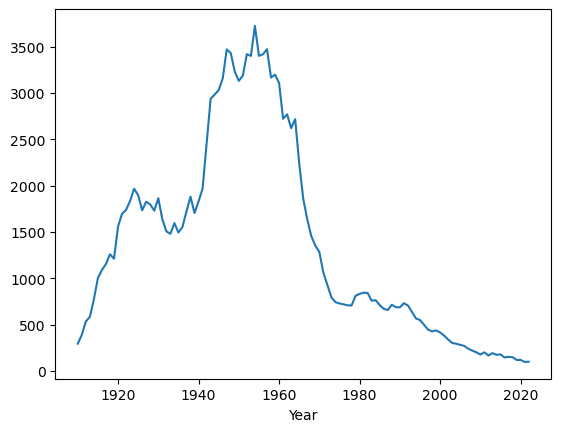

In [15]:
#After looking at the above table I saw Mary was number one so I took for the code below. 
name="Mary"
babynames[babynames["Name"]==name].groupby("Year").agg(sum)["Count_x"].plot()



<Axes: xlabel='Year'>

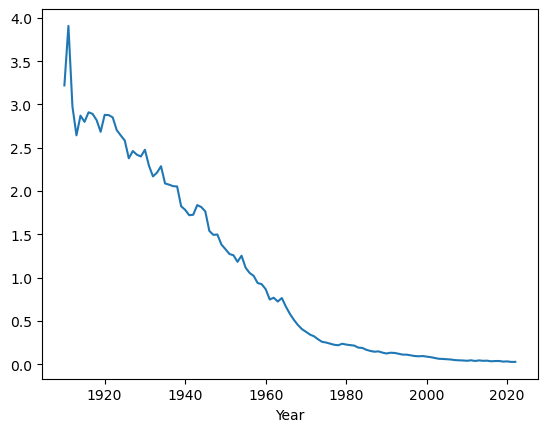

In [16]:
babynames[babynames["Name"]==name].groupby("Year").agg(sum)["percent"].plot()

<Axes: xlabel='Year'>

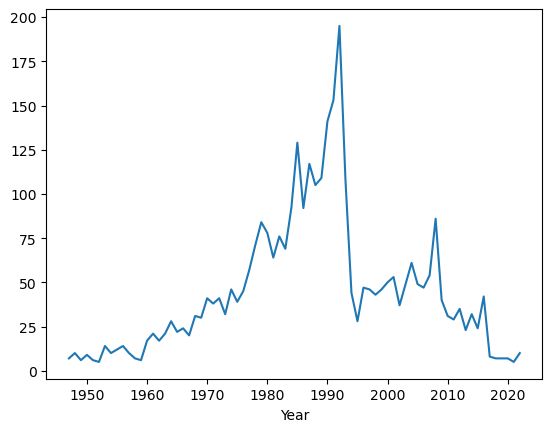

In [17]:

#There are also interesting social/cultural patterns.  
#What does the popularity graph for the name "Hillary" look like? 
#  Can you suggest other names to try?

babynames[babynames["Name"]=="Hillary"].groupby("Year").agg(sum)["Count_x"].plot()


<Axes: xlabel='Year'>

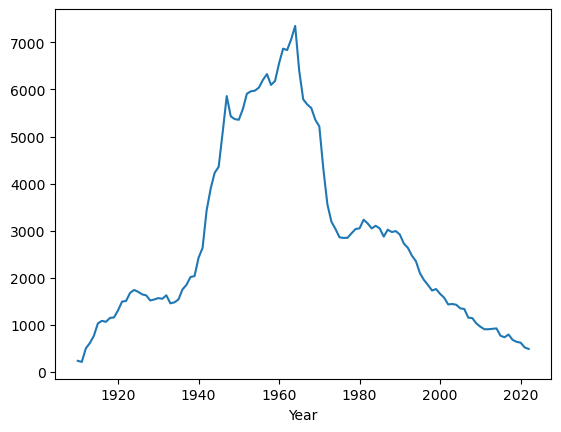

In [18]:
babynames[babynames["Name"]=="John"].groupby("Year").agg(sum)["Count_x"].plot()

<Axes: xlabel='Year'>

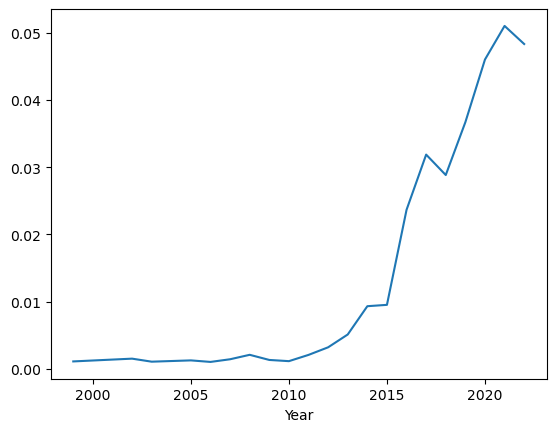

In [23]:
#How about famous people? Here's "Zayn" I picked it because it's a fairly rare name that 
# from a member of the band One Direction.  Notice it doesn't exist at all before  about 2000 and has
# rocketed up in popularity recently. 

babynames[babynames["Name"]=="Zayn"].groupby("Year").agg(sum)["percent"].plot()

<Axes: xlabel='Year'>

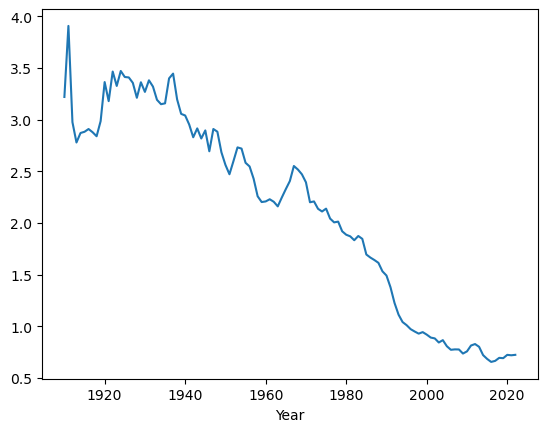

In [24]:
#How much more diverse have names gotten over the century? Lot's of ways to quantify this.  We had looked at the number of unique names before.  Lets now try looking at the percentage of babies given the most popular name.  

#We can groupby and take the max
babynames.groupby("Year").agg(max)["percent"].plot()

<Axes: xlabel='Year'>

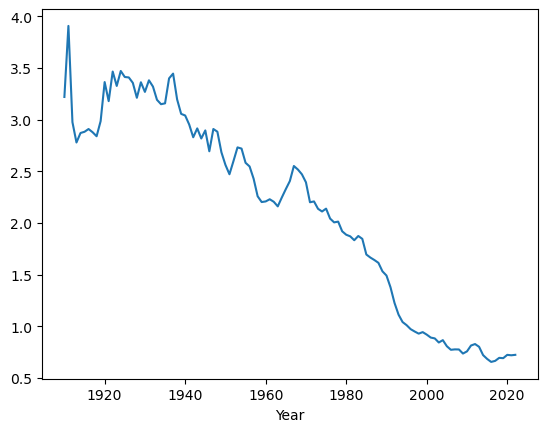

In [25]:
#Or use a sort_values and "first" 
babynames.sort_values("percent",ascending=False).groupby("Year").first()["percent"].plot()

In [33]:
babynames

,State,Sex,Year,Name,Count_x,Count_y,percent
0,CA,F,1910,Mary,295,9163,3.219470
1,CA,F,1910,Helen,239,9163,2.608316
2,CA,F,1910,Dorothy,220,9163,2.400960
3,CA,F,1910,Margaret,163,9163,1.778893
4,CA,F,1910,Frances,134,9163,1.462403
...,...,...,...,...,...,...,...
407423,CA,M,2022,Zayvier,5,360023,0.001389
407424,CA,M,2022,Zia,5,360023,0.001389
407425,CA,M,2022,Zora,5,360023,0.001389
407426,CA,M,2022,Zuriel,5,360023,0.001389


<Axes: xlabel='Year'>

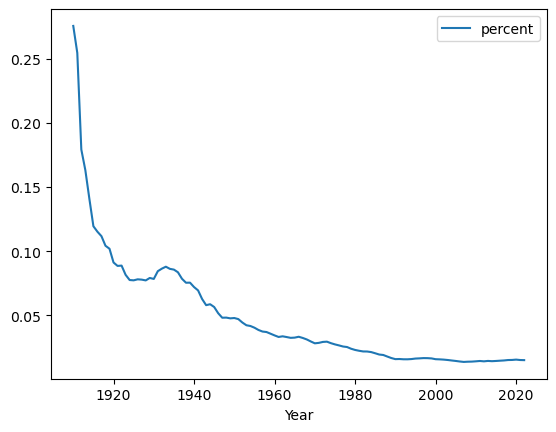

In [62]:

# CValculate the mean of the percentage:
babynames.groupby("Year").agg({"percent":np.mean}).plot()

<Axes: xlabel='Year'>

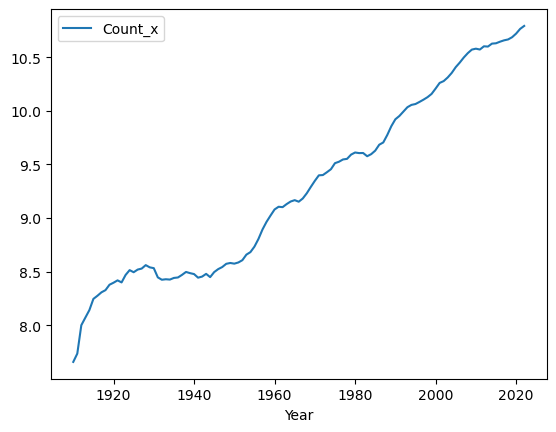

In [60]:
#Here is a more complex way
import scipy.stats

#Define a function that wraps the scipy.stats.entropy function so we can use it in a groupby
def my_entropy(x):
    return scipy.stats.entropy(x,base=2) #Using base 2 for "bits"

#Count_x contains the counts of all the different babynames for a given year.
babynames.groupby(["Year"]).agg({"Count_x":my_entropy}).plot()
#This plot shows entropy has been rising so the differences in names has

Note that the above two ways show slightly different details. But agree on the shape of the trend.  Entropy is the more correct way as it incorporates the entire distriubution and uses probability theory to calculate a probality if getting the same thing.   But you can often get a general idea by using something that relates to the quantity you are trying to get at. 